### Install and import libraries

In [1]:
# If needed, install libraries (run once in your environment)
# !pip install lifelines scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import CoxPHFitter

from sklearn.model_selection import KFold
from lifelines.utils import k_fold_cross_validation


### Load dataset

In [2]:
# Load the Telco Customer Churn dataset from the project folder
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


###  Quick data overview

In [3]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Shape: (7043, 21)

Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecur

### Basic cleaning: handle TotalCharges as numeric and drop missing

In [4]:
# TotalCharges sometimes comes as object; coerce to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing TotalCharges after coercion
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

print("Shape after dropping rows with missing TotalCharges:", df.shape)


Shape after dropping rows with missing TotalCharges: (7032, 21)


### Define survival variables (time and event)

In [5]:
# time: tenure (months)
time_col = "tenure"

# event: churn (Yes=1, No=0)
df["Churn_event"] = df["Churn"].map({"Yes": 1, "No": 0})

df[["tenure", "Churn", "Churn_event"]].head()


,tenure,Churn,Churn_event
0,1,No,0
1,34,No,0
2,2,Yes,1
3,45,No,0
4,2,Yes,1


### Basic exploratory plots of main variables

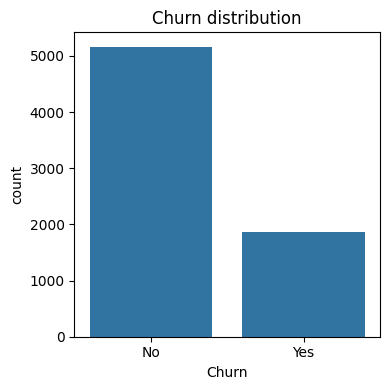

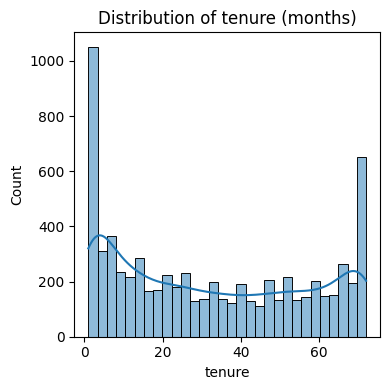

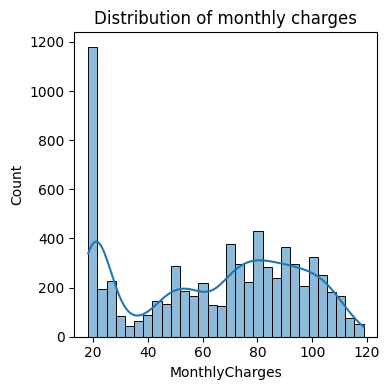

In [7]:
# 1) Churn distribution
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x="Churn")
plt.title("Churn distribution")
plt.tight_layout()
plt.savefig("churn_distribution.png", dpi=300)   # saved as a separate file
plt.show()

# 2) Tenure distribution
plt.figure(figsize=(4, 4))
sns.histplot(df["tenure"], bins=30, kde=True)
plt.title("Distribution of tenure (months)")
plt.tight_layout()
plt.savefig("tenure_distribution.png", dpi=300)
plt.show()

# 3) Monthly charges distribution
plt.figure(figsize=(4, 4))
sns.histplot(df["MonthlyCharges"], bins=30, kde=True)
plt.title("Distribution of monthly charges")
plt.tight_layout()
plt.savefig("monthly_charges_distribution.png", dpi=300)
plt.show()


### Kaplan–Meier curves by Contract type

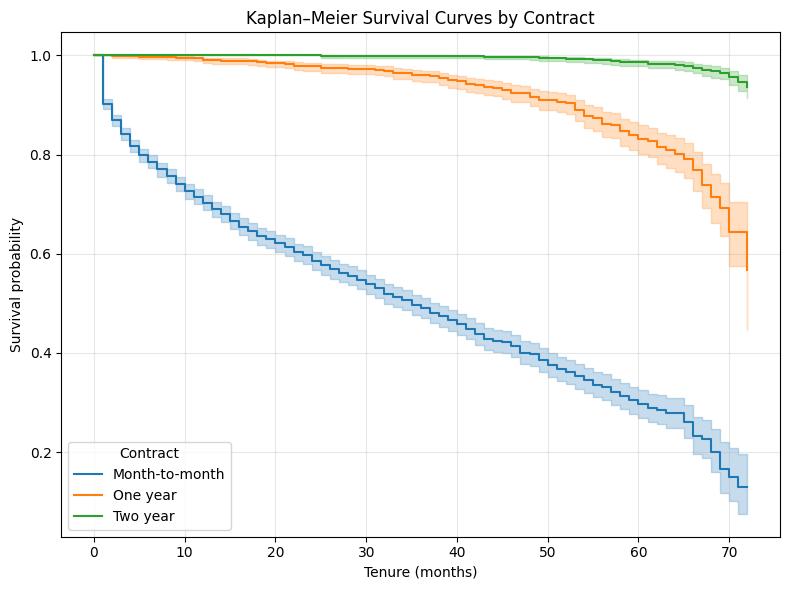

In [12]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for name, grouped_df in df.groupby("Contract"):
    kmf.fit(
        durations=grouped_df[time_col],
        event_observed=grouped_df["Churn_event"],
        label=name
    )
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Survival Curves by Contract")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival probability")
plt.legend(title="Contract")
plt.grid(True, alpha=0.3)

# Save figure (choose your name and format)
plt.tight_layout()
plt.savefig("km_survival_by_contract.png", dpi=300)  # or .pdf, .svg, etc.

plt.show()


###  Global log-rank test for Contract groups

In [9]:
# Global log-rank test comparing survival across all contract types
results_contract = multivariate_logrank_test(
    event_durations=df[time_col],
    groups=df["Contract"],
    event_observed=df["Churn_event"]
)

print("Global log-rank test for Contract:")
print(results_contract.summary)


Global log-rank test for Contract:
   test_statistic    p  -log2(p)
0     2352.872538  0.0       inf


### Pairwise log-rank tests for Contract groups

In [10]:
contract_types = df["Contract"].unique()
pairwise_results = []

for i in range(len(contract_types)):
    for j in range(i + 1, len(contract_types)):
        g1 = contract_types[i]
        g2 = contract_types[j]
        df1 = df[df["Contract"] == g1]
        df2 = df[df["Contract"] == g2]
        
        res = logrank_test(
            df1[time_col], df2[time_col],
            event_observed_A=df1["Churn_event"],
            event_observed_B=df2["Churn_event"]
        )
        pairwise_results.append({
            "Group 1": g1,
            "Group 2": g2,
            "Test statistic": res.test_statistic,
            "p-value": res.p_value
        })

pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df


,Group 1,Group 2,Test statistic,p-value
0,Month-to-month,One year,926.064559,2.117327e-203
1,Month-to-month,Two year,1550.510307,0.000000e+00
2,One year,Two year,256.217767,1.145448e-57


### Kaplan–Meier curves by PaymentMethod

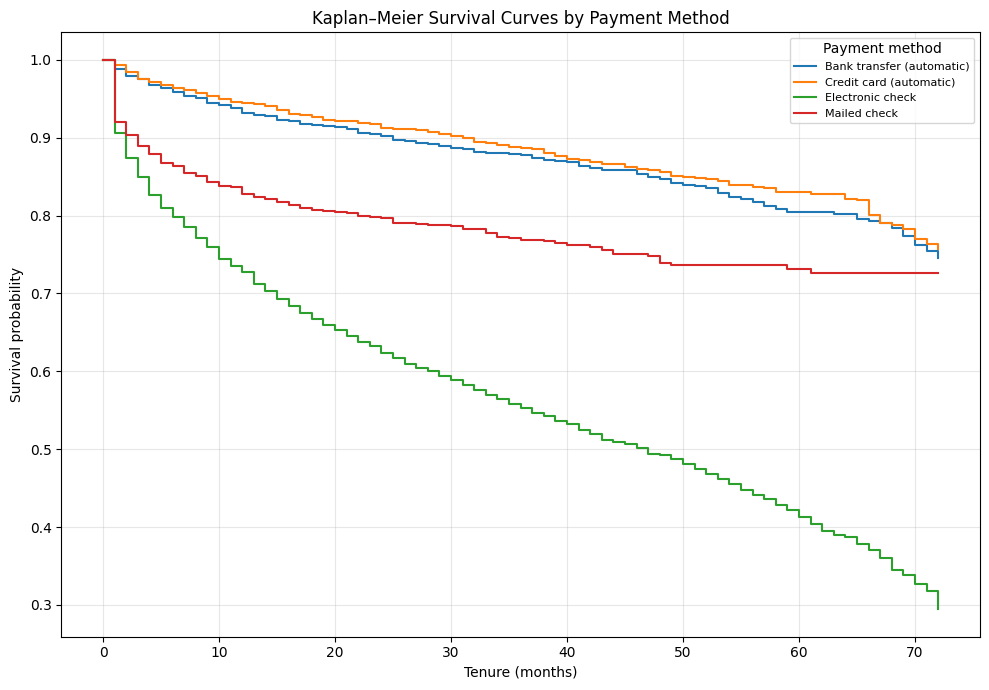

In [13]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 7))

for name, grouped_df in df.groupby("PaymentMethod"):
    kmf.fit(
        durations=grouped_df[time_col],
        event_observed=grouped_df["Churn_event"],
        label=name
    )
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival Curves by Payment Method")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival probability")
plt.legend(title="Payment method", fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("km_survival_by_payment_method.png", dpi=300)  # choose name/format

plt.show()
